/Users/omerhacohen/ws/pixel-brain/venv/lib/python3.8/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/Users/omerhacohen/ws/pixel-brain/venv/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [17:32:49] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Testing RMSE: 0.6900682163966552
Testing AUC: 0.5


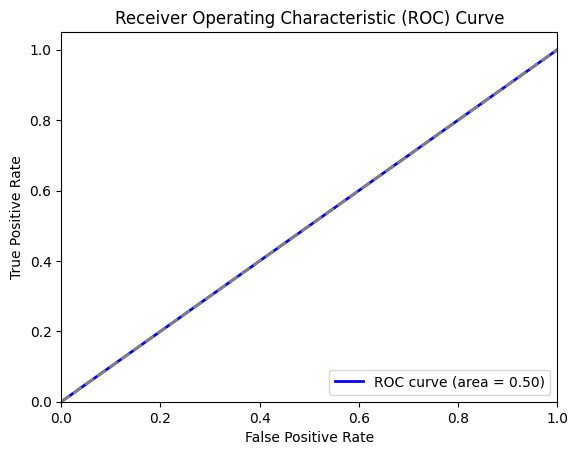

In [1]:
from pixelbrain.database_processors.xgboost_processor import XGBoostDatabaseRegressorTrainer, XGBoostDatabaseProcessor
from pixelbrain.database import Database
import os
import numpy as np

mongo_key=os.getenv("MONGO_URL")
db = Database(database_id="Selfyx", mongo_key=mongo_key)

data_field_names = [
    "cfg_scale",
    "pick_score",
    "similarity_score_nearest",
    "similarity_score_average_k_nearest",
    "similarity_score_maximum_distance",
    "generated_epoch"
]

metric_field_name = "human_rating"
trainer = XGBoostDatabaseRegressorTrainer(db, data_field_names, metric_field_name)
rmse, auc = trainer.fit(save_model_path="xgboost_rating_model.pkl", auc_threshold=4, plot_auc_curve=True)



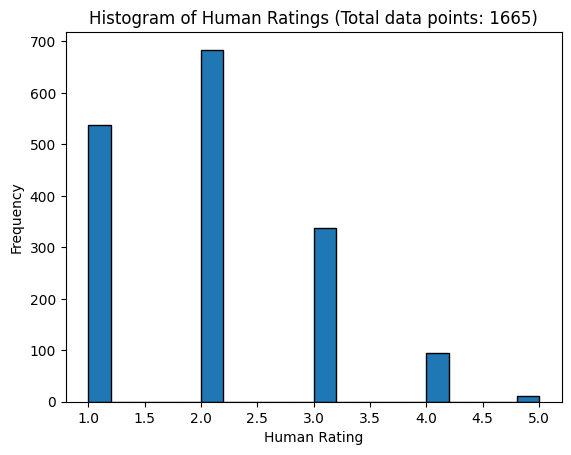

Total data points: 1665
Data points with metric more then 4: 106
Data points with metric more then 3: 444


In [2]:
import matplotlib.pyplot as plt
import numpy as np
# Fetch the data from the database
data = db.find_images_with_fields(data_field_names + [metric_field_name])

# Extract the metric values
metric_values = np.array([record[metric_field_name] for record in data])
nof_metrics_more_then_4 = np.sum(np.where(metric_values >= 4, 1, 0))
nof_metrics_more_then_3 = np.sum(np.where(metric_values >= 3, 1, 0))
# Plot the histogram
plt.hist(metric_values, bins=20, edgecolor='black')
plt.title(f'Histogram of Human Ratings (Total data points: {len(metric_values)})')
plt.xlabel('Human Rating')
plt.ylabel('Frequency')
plt.show()

print(f'Total data points: {len(metric_values)}')
print(f'Data points with metric more then 4: {nof_metrics_more_then_4}')
print(f'Data points with metric more then 3: {nof_metrics_more_then_3}')



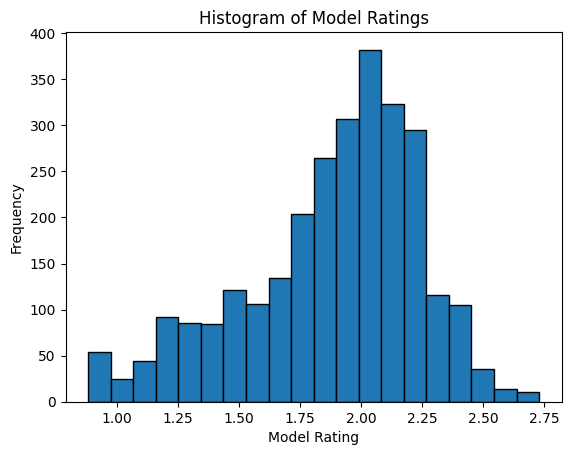

In [3]:
predictor = XGBoostDatabaseProcessor(db, data_field_names, model_path="xgboost_rating_model.pkl")

def plot_predictor_histogram(predictor):
    prep_data = predictor.get_prepared_data()
    predictions = predictor.predict(prep_data)

    # Plot the histogram
    plt.hist(predictions, bins=20, edgecolor='black')
    plt.title('Histogram of Model Ratings')
    plt.xlabel('Model Rating')
    plt.ylabel('Frequency')
    plt.show()

plot_predictor_histogram(predictor)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Testing RMSE: 0.7974455024668337
Testing AUC: 0.5


/Users/omerhacohen/ws/pixel-brain/venv/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [17:35:59] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


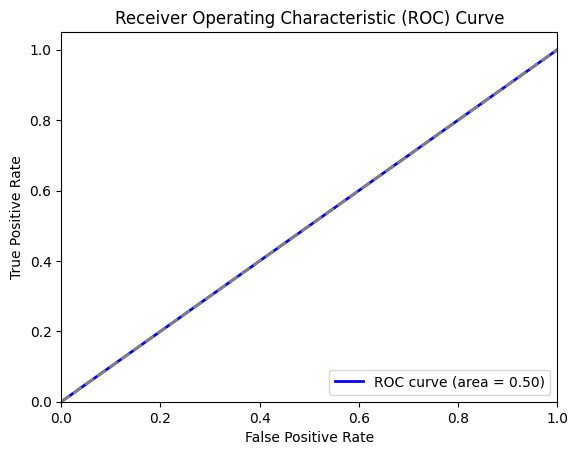

In [6]:
def mse_weights(y_true):
    weights = np.where(y_true >= 3, 20, 1)
    return weights

trainer_new_metric = XGBoostDatabaseRegressorTrainer(db, data_field_names, metric_field_name, mse_weights_func=mse_weights)
rmse, auc = trainer_new_metric.fit(save_model_path="xgboost_rating_model_new_metric.pkl", auc_threshold=4, plot_auc_curve=True)



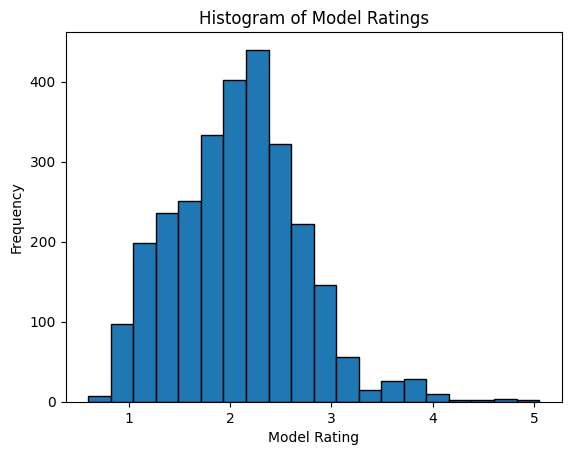

[2.8476727 2.4948614 2.3215013 ... 1.1882764 1.2956724 1.051843 ]
13


In [7]:
new_predictor = XGBoostDatabaseProcessor(db, data_field_names, model_path="xgboost_rating_model_new_metric.pkl")
plot_predictor_histogram(new_predictor)
new_prep_data = new_predictor.get_prepared_data()
new_predictions = new_predictor.predict(new_prep_data)
print(new_predictions)
more_then_4 = np.where(new_predictions >= 4, 1, 0)
print(sum(more_then_4))
